# Задача для страховой компании

***
### Задача:

Нужно защитить данные клиентов страховой компании.
    
Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Необходимо обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

<br/>

***

### План работы:

**[Шаг 1.](#section_1)** Загрузка, изучение и обработка данных.

**[Шаг 2.](#section_2)** Создание модели линейной регрессии и анализ преобразования данных.

**[Шаг 3.](#section_3)** Реализация алгоритма преобразования данных.

**[Шаг 4.](#section_4)** Общий вывод.

<br/>


<a id='section_1'></a>
### Шаг 1. Загрузка, изучение и обработка данных

In [1]:
#Загрузка необходимых библиотек:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
#Сохраняем данные в датафрейм
df = pd.read_csv('C:/Users/ratus/DATA_SCIENCE/итоговые проекты/8/insurance.csv')

In [3]:
#Общая информация по датафрейму и несколько строк
df.info()
print (display(df.sample(5)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
18,1,42.0,49700.0,0,1
711,1,47.0,36700.0,1,1
824,0,22.0,29100.0,2,0
241,1,27.0,32400.0,1,0
3244,1,25.0,24700.0,2,0


None


В датафрейме содержится информация о 5тыс клиентов.

Пропусков в датафреймах нет.

С типами данных все в порядке, только возраст нужно поменять на целочисленный тип, так как возраст это всегда целое число.

Названия столбцов не соответствуют стилю snake_case, переименуем:

In [4]:
#Переименовываем
df = df.rename(columns = {'Пол': 'gender', 
                          'Возраст':'age',
                          'Зарплата':'salary',
                          'Члены семьи':'family_members',
                          'Страховые выплаты':'insurance_payments'
                         } )

#Проверяем
df.columns

Index(['gender', 'age', 'salary', 'family_members', 'insurance_payments'], dtype='object')

Изменим тип столбца, содержащего возраст:

In [5]:
#Меняем тип данных столбца ежемесячного дохода на целочисленный (int)
df['age'] = df['age'].astype(int)

Посмотрим данные на наличие аномальностей и выбросов:

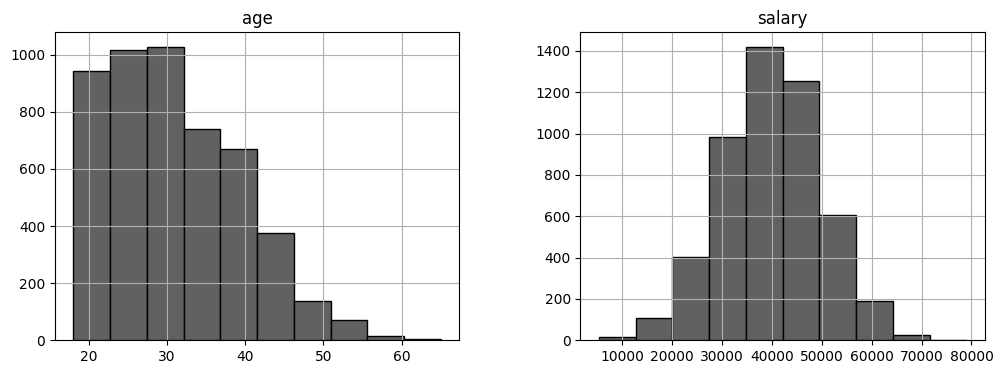

In [6]:
# Общая гистограмма для числовых столбцов
df[['age','salary']].hist(
    figsize=(12,4), 
    color = '#616161', edgecolor = 'black');

In [7]:
df['family_members'].unique()

array([1, 0, 2, 4, 3, 5, 6], dtype=int64)

In [8]:
df['insurance_payments'].unique()

array([0, 1, 2, 3, 5, 4], dtype=int64)

In [9]:
df['gender'].unique()

array([1, 0], dtype=int64)

In [10]:
df.describe()

,gender,age,salary,family_members,insurance_payments
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Выбивающихся значений не обнаружено. 

Проверим есть ли в данных дубликаты:

In [11]:
#Ищем дубликаты по всему датафрейму
print (df.duplicated().sum())

153


В данных 153 дублирующих строки неизвестного для нас происхождения, удалим их.

In [12]:
# удаляем дубликаты
df = df.drop_duplicates() 

# проверяем количество дубликатов
df.duplicated().sum()

0

<a id='section_2'></a>
### Шаг 2. Создание модели линейной регрессии и анализ преобразования данных

Разделим данные на обучающую (75%) и валидационную (25%) выборки:

In [13]:
#Выделяем общие признаки и целевой
features = df.drop('insurance_payments', axis=1)
target = df['insurance_payments']

#Отделим 25% в валидационную выборку features_valid, target_valid
#оставшиеся 75% будут в обучающей features_train,target_train
features_train, features_valid, target_train, target_valid = train_test_split(
   features, target, test_size = 0.25, random_state=123) 

#Проверим размер выборок
print (len(features_train), len(features_valid))

3635 1212


Введем обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Минимальное MSE получается когда веса равны:

$$
w = (X^T X)^{-1} X^T y
$$

Определим теперь класс модели линейной регрессии:

In [14]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = (np.linalg.inv(X.T.dot(X))).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

Посмотрим на результаты линейной модели:

In [15]:
model_lr = LinearRegression()
#обучаем
model_lr.fit(features_train, target_train)

#Делаем предсказание
predictions = model_lr.predict(features_valid)

#Смотрим качество
print(f'метрика R2 = {r2_score(target_valid, predictions):.2f}')

метрика R2 = 0.41


#### Шаг 2.1. Проверим, изменится ли качество линейной регрессии если признаки умножить на обратимую матрицу $P$

In [16]:
def get_rand_matrix(shape):
    """
    Функция для генерации квадратной случайной обратимой матрицы.
    На вход принимает размер матрицы.
    Возвращает сгенерированную матрицу.
    """
    #Переменная хранящая значение определителя матрицы
    det = 0
    
    #Матрица, обратная к A, существует тогда и только тогда, 
    #когда матрица A невырожденна
    # т.е. когда ее определитель не равен нулю
    while det == 0:
        matrix = np.random.normal(0,1, size=(shape, shape))
        det = np.linalg.det(matrix)
    return matrix

In [17]:
#Создадим случайную квадратную матрицу с n = кол-ву признаков
matrix_P = get_rand_matrix(features_train.shape[1])

matrix_P

array([[ 4.21954980e-01, -2.76955704e-01, -9.50945513e-01,
         1.21583563e-01],
       [-5.57183289e-02,  9.12688265e-02, -1.04643143e-01,
        -1.76283029e+00],
       [ 7.84088286e-02, -9.54420243e-01,  5.40211988e-02,
        -5.97034542e-01],
       [ 3.26177588e-01,  9.56404602e-01, -1.84746233e-01,
        -1.16500685e-03]])

Проверим теперь как влияет домножение признаков на эту матрицу на качество модели:

In [18]:
#Домножаем признаки на полученную обратимую матрицу
features_train_p = features_train.dot(matrix_P)
features_valid_p = features_valid.dot(matrix_P)

print ('Несколько строк преобразованной матрицы признаков:')
features_train_p.sample(5)

Несколько строк преобразованной матрицы признаков:


,0,1,2,3
1654,3008.773590,-36644.765088,2069.624990,-23003.692101
2676,4304.230265,-52392.520391,2962.593497,-32821.270594
4121,2389.988672,-29105.487201,1642.325146,-18279.946316
4745,2782.772813,-33877.724087,1914.766987,-21238.799319
2974,2327.563992,-28342.860546,1601.419494,-17779.523473


In [19]:
#Задаем новую модель
model_lr2 = LinearRegression()

#обучаем на преобразованных данных
model_lr2.fit(features_train_p, target_train)

#Делаем предсказание на преобразованных данных
predictions2 = model_lr2.predict(features_valid_p)

#Смотрим качество
print(f'метрика R2 = {r2_score(target_valid, predictions2):.2f}')

#Проверяем одинаковые ли получили предсказания?
print((
    round(predictions2, 2) == round(predictions, 2)
).sum() == predictions.shape[0])

метрика R2 = 0.41
True


Домножение матрицы признаков на случайную обратимую матрицу не изменяет качество модели. Предсказания совпадают как минимум до второго знака после запятой.

Подставим в формулу, и проверим, что в общем случае домножение на обратимую квадратную матрицу $P$ не изменяет результат предсказания, т.е что $a = a_p$ :

$$ a = Xw = X (X^T X)^{-1} X^T y $$
$$ a_p = XPw $$

где $ w = (X^T X)^{-1} X^T y$

<br>

Для этого вспомним некоторые свойства матриц:

1) $ X^{-1}X = E $

2) $ E X = X E =X $

3) $(X P)^{-1} = P^{-1} X^{-1} $

4) $(X^T)^{-1} = (X^{-1})^T $

5) $(X P)^T = X^T P^T $

6) $(ABС)^{-1} = ((AB)С)^{-1} = ((AB)С)^{-1} = С^{-1}(AB)^{-1} = С^{-1}B^{-1}A^{-1}$

И не забываем, что только квадратная матрица может иметь обратную.

<br>

Подставляем и преобразуем нашу формулу весов с домножением:

$$
w_p = ((XP)^T XP)^{-1} (XP)^T y = (P^T(X^T X) P)^{-1} P^T X^T y =P^{-1}(X^T X)^{-1} (P^T)^{-1} P^T X^T  y =  P^{-1}(X^T X)^{-1} X^T y
$$

Подставим теперь значение весов в формулу предсказания:
$$ a_p = XPw_p = X P P^{-1} (X^T X)^{-1} X^T y =  X (X^T X)^{-1} X^T y $$

Получили равенство $a = a_p$, что доказывает неизменность результата предсказания при домножении признаков на обратимую матрицу $P$, и соответсвенно качество предсказания также не изменяется.

Как видно выше $w_p = P^{-1}w $ Параметры моделей связаны обратной матрицей $P$

***

<div class="info">
<font size="4"><b>Способ доказательства №2:</b></font>
    
Для нашей модели линейной регрессии надо найти такие параметры модели (набор весов $w$) чтобы функция потерь была минимальной (эта функция принимает на вход правильные ответы и предсказания, и возвращает число - потерю). 
    
Один из простых способов найти такие значения параметров модели (вектор $w$) - метод наименьших квадратов, который минимизирует среднеквадратичную ошибку между реальным значением и прогнозом выданным моделью.                                                  

Вспомним формулу среднеквадратичного отклонения, которая в нашем случае будет выглядеть так:
    
$\begin{equation} MSE=\sum_{i=1}^n {(y_i - Xw)^{2}} \end{equation}$
    
Эта формула представляет собой функцию $F(y,X,w)$. Для каждой конкретной линейной функции, которую задают веса, мы получаем число, которое оценивает, насколько точно эта функция приближает наши значения.
Нам надо найти лучшее приближение, т.е. минимальное значение этой функции(минимизировать среднеквадратичную ошибку).
    
Для поиска минимума надо взять первую производную и приравнять к нулю ( в нашем случае матричное дифференцирование). Вспомним некоторые свойства:
    
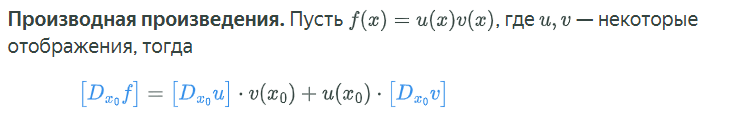
    
берем производную по $w$
    
$$F'_w = <(y - Xw),(y - Xw)>'$$
    
Применим формулу дифференциала произведения, и воспользуемся симметричностью скалярного произведения:
    
$$F'_w  = <(y - Xw)',(y - Xw)> + <(y - Xw),(y - Xw)'> = 2 <(y - Xw), -X> = -2X^{T}(y - Xw) = 2X^{T}Xw -2X^{T}y$$
    
Приравняем теперь к нулю:

$$ 2X^{T}Xw -2X^{T}y = 0$$

$$ 2X^{T}Xw = 2X^{T}y $$

$$ w = (X^{T}X)^{-1} X^{T}y$$ 

Можно предполагать, что минимум достигается при данном значении $w$, где градиент обращается в ноль, но чтобы с уверенностью сказать о том что это минимум, необходимо проверить положительна ли вторая производная. 
    
$$F"_w = (2X^{T}Xw -2X^{T}y)' = 2X^{T}X $$

Вторая производная константная не зависит от $w$ что и логично, так как в исходной функции у нас была вторая степень. 
$X^{T}X$ это квадратная матрица, положительно определенная, соответсвенно при заданном значении $ w = (X^{T}X)^{-1} X^{T}y$  достигается минимум. 
    
Предсказания вычисляются по формуле $$ a = Xw $$
    
Посмотрим какая производная, минимумы и предсказания получились бы при домножении матрицы $XP$:

$$F'_w  = <(y - XPw_p)',(y - XPw_p)> + <(y - XPw_p),(y - XPw_p)'> = 2 <(y - XPw_p), -XP> = -2(XP)^{T}(y - XPw_p) = 2(XP)^{T}XPw_p -2(XP)^{T}y = 2P^{T}X^{T}XPw_p -2P^{T}X^{T}y$$
    
Приравняем теперь к нулю:

$$2P^{T}X^{T}XPw_p - 2P^{T}X^{T}y = 0$$ 

$$P^{T}X^{T}XPw_p = P^{T}X^{T}y $$

$$w_p = (P^{T}X^{T}XP)^{-1}P^{T}X^{T}y $$

$$w_p = P^{-1}(X^{T}X)^{-1}(P^{T})^{-1}P^{T}X^{T}y $$
    
$$w_p = P^{-1}(X^{T}X)^{-1}X^{T}y $$    
    
Ну а дальше подставляем наши веса в формулу предсказаний
    
$$ a_p = XPw_p = X P P^{-1} (X^T X)^{-1} X^T y =  X (X^T X)^{-1} X^T y $$

Получили равенство $a = a_p$, что доказывает неизменность результата предсказания при домножении признаков на обратимую матрицу $P$, и соответсвенно качество предсказания также не изменяется.

Как видно выше $w_p = P^{-1}w $ Параметры моделей связаны обратной матрицей $P$

***

<font size="4"><b>Способ доказательства №3:</b></font>
    
Для исходных данных мы решаем это  
    
$$
w = \arg\min_w MSE(Xw, y)
$$
    
  
Для преобразованных данных решаем это  
    
$$
w_P = \arg\min_w MSE(XPw_p, y)
$$  
    
    
Сделаем замену   w_p на $P^{-1}w$ (Конечно мы это соотношение не берём из первого доказательства, иначе смысла в этом доказательстве просто нет. Тут из разряда математической интуиции, исходя из того, что нам нужно избавиться от P пробуем такую замену.)
 
И подставим:    
    
$$
\arg\min_w MSE(XPP^{-1}w, y)
$$
    
сократим и получим 
    
$$
\arg\min_w MSE(Xw, y)
$$    
  
Получается если заменить $w_p$ на $P^{-1}w$, то получаем ту же самую постановку задачи!  
     

<a id='section_3'></a>
### Шаг 3. Алгоритм преобразования данных для решения задачи

Проведя исследования в шаге 2, мы по сути создали подходящий алгоритм преобразования данных, на котором и остановимся.

**Алгоритм преобразования:**

1) Генерируется обратимая матрица случайных значений размерностью $n*n$, где $n$ = количеству общих признаков задачи;
2) На полученную обратимую матрицу домножаются все признаки, кроме целевого.

После этих шагов данные можно подавать в модель.

В шаге 2 также было обосновано что при таком преобразовании, предсказания и качество линейной регрессии не поменяется, но при этом мы можем обеспечить защиту данных клиента. При таком раскладе восстановить исходную персональную информацию о клиентах представляется практически невозможным.

**Код алгоритма:**

    1)




In [20]:
def get_rand_matrix(shape):
    """
    Функция для генерации квадратной случайной обратимой матрицы.
    На вход принимает размер матрицы.
    Возвращает сгенерированную матрицу.
    """
    #Переменная хранящая значение определителя матрицы
    det = 0
    
    #Матрица, обратная к A, существует тогда и только тогда, 
    #когда матрица A невырожденна
    # т.е. когда ее определитель не равен нулю
    while det == 0:
        matrix = np.random.normal(0,1, size=(shape, shape))
        det = np.linalg.det(matrix)
    return matrix

In [21]:
#Создадим случайную квадратную матрицу с n = кол-ву признаков
matrix_P = get_rand_matrix(features_train.shape[1])

matrix_P

array([[ 0.02936236, -0.47781636, -0.83801362,  1.75477089],
       [ 0.60924816, -2.820579  ,  0.16677195, -0.57684566],
       [ 0.23339649,  1.12779187, -0.18403109,  1.37370196],
       [ 0.72995666,  0.82908634,  1.18716682, -0.74274446]])

    2)

In [22]:
#Выделяем общие признаки
features = df.drop('insurance_payments', axis=1)

#Домножаем признаки на полученную обратимую матрицу
features_p = features.dot(matrix_P)

print ('Несколько строк преобразованной матрицы признаков:')
features_train_p.sample(5)

Несколько строк преобразованной матрицы признаков:


,0,1,2,3
4656,3089.267791,-37600.696333,2125.021932,-23558.298297
694,2100.416925,-25572.036956,1441.867932,-16074.446502
3872,3189.066310,-38841.344395,2194.581709,-24368.056231
976,2900.855596,-35308.218658,1994.139877,-22143.044865
3691,2703.703496,-32923.712636,1860.302675,-20652.340594


В переменной features_p получаем необходимую преобразованную матрицу.

<a id='section_4'></a>
### Шаг 4. Общий вывод


<br/>

#### Цели исследования

Нужно защитить данные клиентов страховой компании «Хоть потоп»

Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Необходимо обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

<br/> 

#### Полученные данные были изучены и прошли следующую предобработку:

* В полученом датафрейме содержится информация о 5тыс клиентов.

* Пропусков в датафреймах нет.

* С типами данных все в порядке, только тип признака возраст был изменен на целочисленный, так как возраст это всегда целое число.

* Все названия признаков были переименованы для соответствия стилю snake_case.

* Аномальных значений не обнаружено. 

* В данных было обнаружено 153 дублирующих строк неизвестного для нас происхождения, которые были удалены. 

* Существенная корреляция наблюдается между возрастом и страховыми выплатами. Между остальными признаками нет ощутимой корреляции.

#### Создание модели линейной регрессии и анализ преобразования данных:

* Была написана модель линейной регрессии. Для оценки качества используется метрика R2.

* Данные были разделены на обучающую (75%) и валидационную (25%) выборки.

* Было  проанализировано преобразование данных путем домножения общих признаков на случайную обратимую матрицу $P$ размерностью $n*n$, где $n$ = кол-ву признаков. Такое преобразование не изменяет предсказания модели и соотвественно не влияет на метрику. Данный вывод был обоснован для общего случая любой квадратной обратимой матрицы.
   
#### Алгоритм преобразования данных для решения задачи:

Было решено остановить выбор на преобразовании данных, проанализированного в шаге 2.

**Алгоритм преобразования:**

1) Генерируется матрица случайных значений размерностью $n*n$, где $n$ = количеству общих признаков задачи;
2) Матрица проверяется на обратимость;
3) На полученную обратимую матрицу домножаются все признаки, кроме целевого.

После этих шагов данные можно подавать в модель. В шаге 2 было обосновано что при таком преобразовании, предсказания и качество линейной регрессии не поменяется, но при этом мы можем обеспечить защиту данных клиента.


<br/>

### Вывод и рекомендации:

По итогу работы можно рекомендовать метод преобразования данных путем домножения на случайную обратимую матрицу как описано выше. 

Такое преобразование позволит защитить данные клиентов. 
Персональную информацию восстановить по таким данных будет практически невозможно, и такие данные при попадании в третьи руки окажутся бесполезными.

<br/>